`April 1, 2022`

### **Hyperparameter Tuning Exercise**

#### **Please use 'insurance' dataset.**

Find the optimal model and hyperparameter to predict individual insurance costs according to their characteristics.

- Explore the data first.
- Use pipelines for preprocessing and modeling as you have learned today.
- You can use parametric or non-parametric models.
- For the optimal model, compare the result before and after tuning.

<hr>

#### **Features Description**

- age: age of primary beneficiary.

- sex: insurance contractor gender: female, male.

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9.

- children: Number of children covered by health insurance / Number of dependents.

- smoker: Smoking.

- region: The beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance.

<hr>

### **Import libraries**

In [49]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

### **Explore dataset**

In [2]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['sex', 'smoker', 'region']

In [7]:
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['charges']))]
num_features

['age', 'bmi', 'children']

In [8]:
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in sex:  2
Unique values:  ['female' 'male']

Total unique values in smoker:  2
Unique values:  ['yes' 'no']

Total unique values in region:  4
Unique values:  ['southwest' 'southeast' 'northwest' 'northeast']



In [9]:
df.corr()['charges']

age         0.299008
bmi         0.198341
children    0.067998
charges     1.000000
Name: charges, dtype: float64

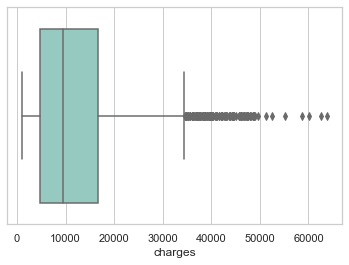

In [10]:
sns.set(style='whitegrid', palette='Set3')
sns.boxplot(x='charges', data=df);

In [3]:
df.corr(method='spearman')

,age,bmi,children,charges
age,1.000000,0.107736,0.056992,0.534392
bmi,0.107736,1.000000,0.015607,0.119396
children,0.056992,0.015607,1.000000,0.133339
charges,0.534392,0.119396,0.133339,1.000000


#### **Plot of categorical features**

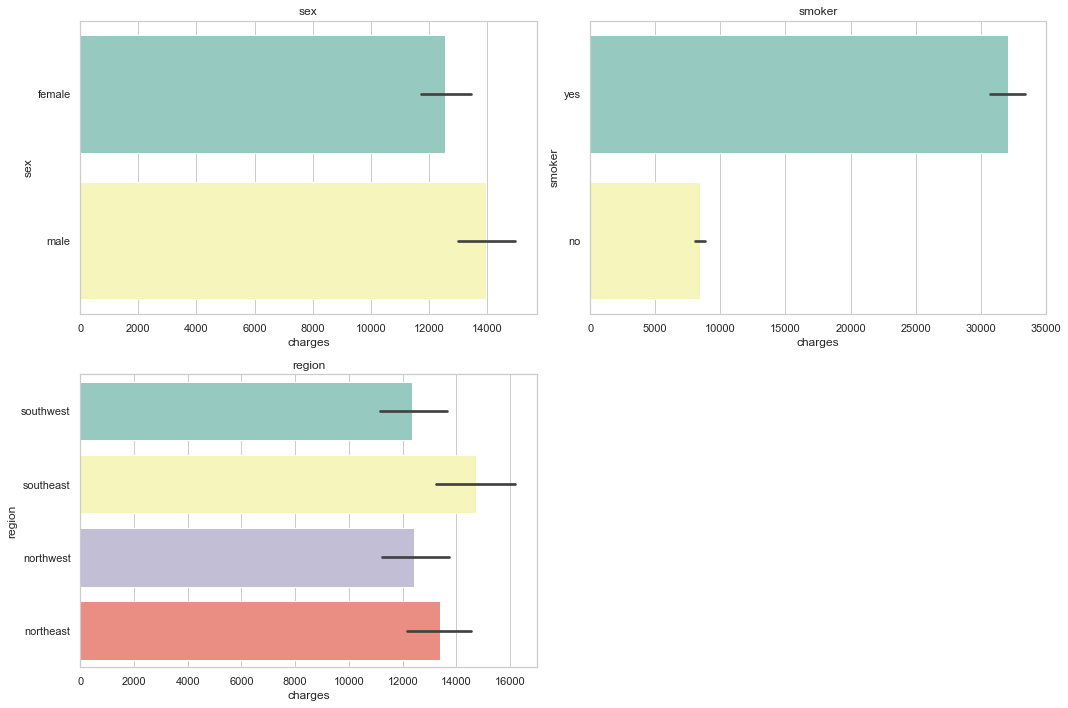

In [33]:
plt.figure(figsize=(15, 10), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1

for feature in cat_features:
    ax = plt.subplot(2, 2, plotnumber)
    sns.barplot(x = 'charges', y = feature, data = df)
    plt.xlabel('charges')
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

#### **Plot of numerical features**

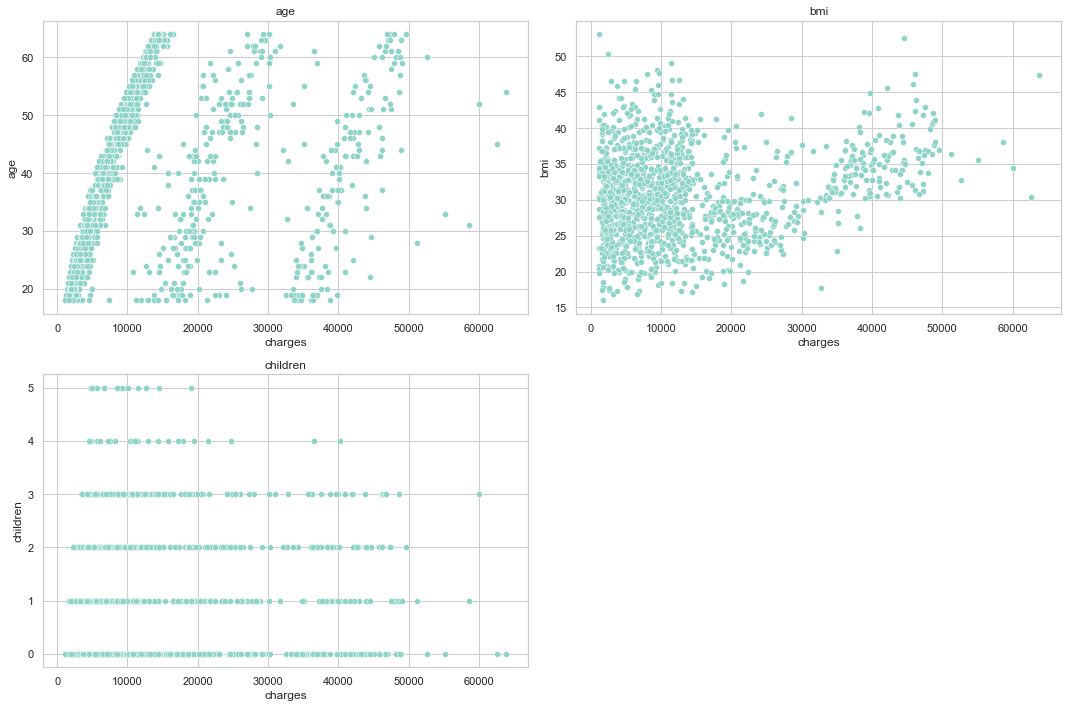

In [12]:
plt.figure(figsize=(15, 10), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1

for feature in num_features:
    ax = plt.subplot(2, 2, plotnumber)
    sns.scatterplot(x = 'charges', y = feature, data = df)
    plt.xlabel('charges')
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

### **Data Splitting**

In [4]:
# Define X and y
X = df.drop(columns='charges')
y = df['charges']

In [5]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=0
)

### **Data Preprocessing**

In [7]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'), ['sex', 'smoker', 'region']),
    ('scaler', RobustScaler(), ['age', 'bmi', 'children'])
], remainder='passthrough')

### **Model benchmark**

In [8]:
# Define the models
linreg = LinearRegression(fit_intercept=True)
knn = KNeighborsRegressor(n_neighbors=5)
tree = DecisionTreeRegressor(criterion='mae', max_depth=5, random_state=0)

# Pipeline
linreg_pipeline = Pipeline([
        ('preprocessing', transformer),
        ('linreg', linreg)
])

knn_pipeline = Pipeline([
        ('preprocessing', transformer),
        ('knn', knn)
])

dt_pipeline = Pipeline([
        ('preprocessing', transformer),
        ('dt', tree)
])

In [18]:
from sklearn import metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [11]:
model_pipelines = [linreg_pipeline, knn_pipeline, dt_pipeline]
mean_score = []
std_score = []

for i in model_pipelines:
    model_cv = cross_val_score(i, X_train, y_train, scoring = 'neg_mean_absolute_error')
    mean_score.append(model_cv.mean())
    std_score.append(model_cv.std())

In [12]:
pd.DataFrame({
    'model':['Linear Regression', 'KNN Regressor', 'Decision Tree Regressor'],
    'mean': mean_score,
    'std': std_score
})

,model,mean,std
0,Linear Regression,-4275.591651,276.448853
1,KNN Regressor,-3773.179018,406.942610
2,Decision Tree Regressor,-2140.367028,298.210629


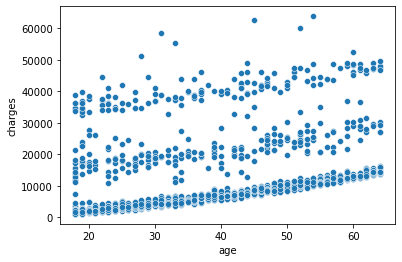

In [17]:
sns.scatterplot(x='age', y='charges', data=df);

**Interpretation**

The decision tree regressor model has the slightest error compared to the others. The difference is quite significant. Only the tree regressor model will be tuned for the following steps. 

### **Model performance in test set**

In [18]:
estimator = Pipeline([
    ('preprocess', transformer),
    ('model', tree)
])

estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker', 'region']),
                                                 ('scaler', RobustScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('model',
                 DecisionTreeRegressor(criterion='mae', max_depth=5,
                                       random_state=0))])

In [19]:
y_pred = estimator.predict(X_test)

In [20]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)

MSE: 24249019.226462997
RMSE: 4924.329317426181
MAE: 1985.4698345485076


### **Hyperparameter Tuning**

In [21]:
X_train_preprocessed = transformer.fit_transform(X_train)
X_test_preprocessed = transformer.transform(X_test)

In [37]:
hyperparam_space= {
    'min_samples_leaf':[1, 5, 10, 15, 20, 50], # benchmark 1
    'max_depth':[3, 4, 5, 6, 7, 9, 10], # benchmark 5
    'criterion':['mse', 'mae', 'rmse'] # benchmark mae
}

In [38]:
tree = DecisionTreeRegressor(criterion='mae', max_depth=5, random_state=0)

grid_search = GridSearchCV(
    tree, # model to tune
    param_grid = hyperparam_space, # hyperparam space
    scoring = 'neg_mean_absolute_error', # metric
    return_train_score = True,
    n_jobs = -1
)

In [39]:
grid_search.fit(X_train_preprocessed, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(criterion='mae', max_depth=5,
                                             random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae', 'rmse'],
                         'max_depth': [3, 4, 5, 6, 7, 9, 10],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 50]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [40]:
print(grid_search.best_score_)
print(grid_search.best_params_)

-1939.4536536028038
{'criterion': 'mae', 'max_depth': 6, 'min_samples_leaf': 5}


In [41]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
61,0.037110,0.001805,0.000798,3.989697e-04,mae,6,5,"{'criterion': 'mae', 'max_depth': 6, 'min_samp...",-1820.555779,-1674.227427,...,-1939.453654,308.067148,1,-1727.265461,-1789.649477,-1723.192805,-1725.830769,-1582.186668,-1709.625036,68.413951
74,0.041790,0.009221,0.000997,6.320364e-04,mae,9,10,"{'criterion': 'mae', 'max_depth': 9, 'min_samp...",-1831.350990,-1685.402867,...,-1947.703001,296.584693,2,-1753.012693,-1800.598016,-1752.192677,-1748.023963,-1624.444037,-1735.654277,58.844284
80,0.042686,0.011941,0.000704,3.963048e-04,mae,10,10,"{'criterion': 'mae', 'max_depth': 10, 'min_sam...",-1832.088496,-1685.402867,...,-1947.850502,296.526969,3,-1752.983366,-1800.598016,-1752.192677,-1748.023963,-1624.444037,-1735.648412,58.842555
67,0.038507,0.001150,0.000798,1.163219e-03,mae,7,5,"{'criterion': 'mae', 'max_depth': 7, 'min_samp...",-1864.961894,-1605.538089,...,-1951.493146,303.984088,4,-1663.159402,-1703.733034,-1644.065145,-1649.155113,-1519.848935,-1635.992326,61.732601
68,0.040593,0.008737,0.000997,3.814697e-07,mae,7,10,"{'criterion': 'mae', 'max_depth': 7, 'min_samp...",-1838.377226,-1693.533349,...,-1954.545290,292.739873,5,-1773.613926,-1814.767059,-1761.050938,-1758.267201,-1636.388679,-1748.817561,59.738431


### **Before and after tuning comparison**

In [42]:
# Re-fitting the model with the best estimator obtained from grid search.
best_model = grid_search.best_estimator_
best_model.fit(X_train_preprocessed, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=6, min_samples_leaf=5,
                      random_state=0)

In [43]:
y_pred_best = best_model.predict(X_test_preprocessed)

In [44]:
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)

print('MSE:', mse_best)
print('RMSE:', rmse_best)
print('MAE:', mae_best)

MSE: 16994102.233397037
RMSE: 4122.390354320783
MAE: 1678.1435176455223


In [45]:
pd.DataFrame({
    'Model':['Decision Tree Regressor'],
    'RMSE before tuning': rmse,
    'MAE before tuning': mae,
    'RMSE after tuning': rmse_best,
    'MAE after tuning': mae_best
})

,Model,RMSE before tuning,MAE before tuning,RMSE after tuning,MAE after tuning
0,Decision Tree Regressor,4924.329317,1985.469835,4122.390354,1678.143518


In [46]:
df.describe()['charges']

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

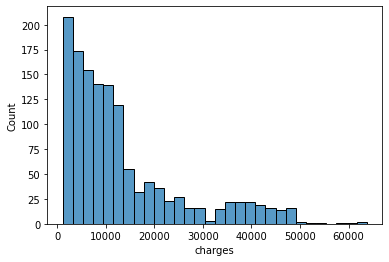

In [47]:
sns.histplot(df['charges']);

**Interpretation**

According to the result above, the performance of the decision tree regressor model improves due to hyperparameter tuning. We only tuned some hyperparameters; the performance significantly changed (MAE after tuning is lower).

This decision tree regressor model is built for the charges range of ~1121 to 63770. The model will produce bias in predicting charge price out of that range. 